### Import Libraries

In [98]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl import config
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

import gym
from gymnasium import spaces

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader


from collections import deque
import random

import matplotlib.dates as mdates
import seaborn as sns

### Download Data

In [2]:
from finrl import config_tickers
df = YahooDownloader(start_date = '2009-01-01',
                           end_date = '2020-09-30',
                           ticker_list = config_tickers.DOW_30_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Shape of DataFrame:  (86111, 8)


### Process Data

In [4]:
df = FeatureEngineer(use_technical_indicator=True,
                      tech_indicator_list = config.INDICATORS,
                      use_turbulence=True,
                      user_defined_feature = False).preprocess_data(df.copy()).fillna(0)

Successfully added technical indicators
Successfully added turbulence index


In [5]:
df=df.sort_values(['date','tic'],ignore_index=True)
df.index = df.date.factorize()[0]
df = df.reset_index(drop=True)

In [6]:
df.sample(5)

date       close        high         low        open     volume  \
33880  2013-08-23   55.433498   61.990002   61.459999   61.959999    5505900   
85341  2020-09-10  102.120384  114.949997  111.769997  113.730003     950200   
21484  2011-12-08   39.474873   49.549999   47.980000   49.230000    8641800   
3807   2009-07-13   19.308424   22.780001   22.070000   22.490000    8433300   
28971  2012-12-20   15.840164   18.935715   18.531429   18.928572  481689600   

        tic  day      macd     boll_ub     boll_lb     rsi_30      cci_30  \
33880   DIS    4 -0.796400   60.733230   54.157697  43.948659 -142.458895   
85341   TRV    3 -0.370539  108.080415  100.834897  48.113396  -96.950727   
21484   UNH    3  0.518211   41.053846   34.751002  53.608243   95.495303   
3807    DIS    0 -0.291774   20.602446   18.768879  49.231850  -98.412982   
28971  AAPL    3 -0.468257   18.438899   15.064810  40.251856  -88.328623   

           dx_30  close_30_sma  close_60_sma  turbulence  
33880  32.321960     57.763206     57.583307   51.393667  
85341  11.030769    104.751734    104.849082    9.449319  
21484  29.962954     37.990538     38.265584   34.715132  
3807   24.052133     20.251164     19.765193    0.000000  
28971  35.723708     16.682505     17.870250   56.725462

### Train-Test Split

In [7]:
train = data_split(df, '2009-01-01','2019-12-31')
trade = data_split(df, '2020-01-01','2020-09-30')

### Environment Setup

In [8]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(config.INDICATORS)*stock_dimension #stock, shares, technical indicators, 

In [9]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension
env_kwargs = {
    "hmax": 100,  # Maximum number of shares that can be bought or sold in a single transaction.
    "initial_amount": 1_000_000,  # Initial cash available for the agent to trade with (e.g., $1,000,000).
    "num_stock_shares": num_stock_shares,  # Initial portfolio: number of shares owned for each stock.
    "buy_cost_pct": buy_cost_list,  # Transaction cost percentage for buying stocks.
    "sell_cost_pct": sell_cost_list,  # Transaction cost percentage for selling stocks.
    "state_space": state_space,  # Dimension of the state space (e.g., features describing the environment).
    "stock_dim": stock_dimension,  # Number of stocks being traded (dimension of the stock universe).
    "tech_indicator_list": config.INDICATORS,  # List of technical indicators used as features for the state space.
    "action_space": stock_dimension,  # Dimension of the action space (one action per stock).
    "reward_scaling": 1e-4,  # Scaling factor for rewards to normalize them and improve learning stability.
    "print_verbosity":5
}

### Custom Trading Environment

In [10]:
class CustomStockTradingEnv(StockTradingEnv):
    def __init__(self, df, **kwargs):
            # Call the parent constructor
            super().__init__(df=df, **kwargs)
            self.action_space = spaces.Box(
            low=-self.hmax, 
            high=self.hmax, 
            shape=(self.stock_dim,), 
            dtype=np.float32
        )
    def save_state_memory(self):
        """Save state memory dynamically without hard-coded column names."""
        if len(self.df.tic.unique()) > 1:
            # Get the date memory (excluding the last one)
            date_list = self.date_memory[:-1]

            # Ensure state_list is not empty
            state_list = self.state_memory
            # print(len(state_list[0]))
            if not state_list:
                print("Warning: state_memory is empty!")
                return pd.DataFrame()  # Return an empty DataFrame if no data exists

            # Ensure each state has the same structure
            try:
                num_features = len(state_list[0])  # Get number of features from the first state
                state_columns = [f"feature_{i}" for i in range(num_features)]  # Generate feature names
            except IndexError:
                print("Error: state_memory contains empty entries.")
                return pd.DataFrame()  # Return an empty DataFrame if there's an issue

            df_date = pd.DataFrame(date_list, columns=["date"])
            df_states = pd.DataFrame(state_list, columns=state_columns)
            df_states.index = df_date["date"]  # Set index to match dates
        else:
            date_list = self.date_memory[:-1]
            state_list = self.state_memory
            df_states = pd.DataFrame({"date": date_list, "states": state_list})

        return df_states
    # def step(self, action):
    #     # Clip actions to feasible shares based on current holdings
    #     # print(action)
    #     for i in range(self.stock_dim):
    #         current_shares = self.state[i * 2 + 1]
    #         action[i] = np.clip(action[i], -current_shares, self.hmax)
        
    #     return super().step(action)
    def step(self, action, state = None):
        # Clip actions to feasible shares based on current holdings
        if state is not None:
            self.state = state
        for i in range(self.stock_dim):
            current_shares = self.state[i * 2 + 1]
            action[i] = np.clip(action[i], -current_shares, self.hmax)
        
        return super().step(action)
    

### Multi-Layer Perceptron

In [11]:
class MetaPolicy(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, hmax=100):
        """
        :param hmax: Maximum shares allowed (used for action scaling)
        """
        super().__init__()
        self.hmax = hmax
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.Tanh()  # Outputs in [-1, 1] for easy scaling
        )
    
    def forward(self, x):
        # Outputs in [-1, 1], scaled to [-hmax, hmax]
        return self.net(x) * self.hmax

### Define Meta Environment

In [12]:
meta_env_train_gym = CustomStockTradingEnv(df=trade, **env_kwargs)
meta_env_train, obs = meta_env_train_gym.get_sb_env()
# print(obs)
num_stocks  = meta_env_train_gym.action_space.shape[0]
state_features_dim = meta_env_train_gym.state_space
num_base_models = 3
input_dim = num_base_models * num_stocks + state_features_dim
output_dim = num_stocks
hidden_dim = 64 

### Get Base Models

In [13]:
agent = DRLAgent(env = meta_env_train)
model_ddpg = agent.get_model("ddpg")
trained_ddpg = model_ddpg.load(config.TRAINED_MODEL_DIR + "/agent_ddpg")
model_ppo = agent.get_model("ppo")
trained_ppo = model_ppo.load(config.TRAINED_MODEL_DIR + "/agent_ppo", device='cpu')
model_a2c = agent.get_model("a2c")
trained_a2c = model_a2c.load(config.TRAINED_MODEL_DIR + "/agent_a2c", device='cpu')

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cuda device
{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}
Using cuda device
{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cuda device


/home/nyuad/miniconda3/envs/finRl/lib/python3.11/site-packages/stable_baselines3/common/save_util.py:167: UserWarning: Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
Exception: code() argument 13 must be str, not int
  warnings.warn(
/home/nyuad/miniconda3/envs/finRl/lib/python3.11/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
/home/nyuad/miniconda3/envs/finRl/lib/python3.11/site-packages/stable_baselines3/common/save_util.py:167: UserW

### Define Meta Model

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
meta_policy_model = MetaPolicy(input_dim, hidden_dim, output_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(meta_policy_model.parameters(), lr=1e-3)

In [16]:
# Initialize replay buffer with a maximum capacity (e.g., 10,000 transitions)
replay_buffer = deque(maxlen=10000)
batch_size = 64  # Number of transitions to sample per training step

### Training (First Iteration)

1. Meta-Policy Input Formation:
At each step, the algorithm first queries each of your three pre-trained base RL models using the current environment state. These models return their respective action vectors. These outputs are then concatenated with the current state features to form a single input vector. This combined input is intended to capture both the “opinions” of the base models and the actual market or environment context.

2. Meta-Policy Decision:
This input vector is fed into your meta-policy neural network (an MLP), which produces a final action vector. Think of the meta-policy as a decision maker that learns to weigh the different base models' recommendations together with the actual state of the market to decide on the best trading action.

3. Environment Interaction & Experience Collection:
The final action produced by the meta-policy is executed in the trading environment. The environment returns the next state, the reward for the action, and whether the episode has ended. This transition—comprising the input vector, the action taken, the reward received, the next state, and a done flag—is stored in a replay buffer. This buffer accumulates experiences over time.

4. Online Learning via Experience Replay:
Once the replay buffer has collected enough samples, the algorithm randomly samples a batch of experiences from it. Using this batch, it performs a training update on the meta-policy network. The loss function in this update is designed (in a policy gradient style) to encourage the network to produce actions that are correlated with higher rewards. In other words, the network is nudged in the direction of decisions that historically resulted in better outcomes.

5. Continuous Improvement:
This process repeats over many episodes. As the meta-policy network is updated with more experience, it gradually learns to better combine the base models’ outputs and state information to produce final actions that maximize rewards in the trading environment.


In [72]:
for episode in range(100):
    state = meta_env_train.reset()
    done = False
    
    while not done:
        # 1. Get base model predictions for CURRENT state
        state = np.array(state).reshape(-1)
        base_actions = []
        for model in [trained_ddpg, trained_ppo, trained_a2c]:
            action, _ = model.predict(state)  # Use current state
            base_actions.append(action)
        base_actions = np.concatenate(base_actions).reshape(-1)
        
        # 2. Prepare meta-policy input
        input_vector = np.concatenate([base_actions, state])
        input_tensor = torch.FloatTensor(input_vector).unsqueeze(0).to(device)
        
        # 3. Predict action (e.g., [-50, 0, 100])
        with torch.no_grad():
            predicted_action = meta_policy_model(input_tensor)
        action = predicted_action.cpu().numpy()
        # print(predicted_action.shape)
        # 4. Take action in the environment
        next_state, reward, done, info = meta_env_train.step(action)
        # print(len(next_state))
        # 5. Store transition in replay buffer
        replay_buffer.append((input_vector, action, reward, next_state, done))
        
        # 6. Batch training (only if buffer has enough samples)
        if len(replay_buffer) >= batch_size:
            # Sample a batch of transitions
            batch = random.sample(replay_buffer, batch_size)
            states, actions, rewards, next_states, dones = zip(*batch)
            # print(len(states[0]))
            # Convert to tensors
            states_tensor = torch.FloatTensor(np.array(states)).to(device)
            actions_tensor = torch.FloatTensor(np.array(actions)).to(device)
            rewards_tensor = torch.FloatTensor(np.array(rewards)).to(device)
            
            # 7. Calculate loss (policy gradient)
            # print(states_tensor.shape)
            predicted_actions = meta_policy_model(states_tensor)
            # print(predicted_action.shape)
            loss = -torch.mean(predicted_actions * rewards_tensor.unsqueeze(-1))  # Maximize reward
            
            print(f"Episode {episode} | Loss: {loss.item()}")
            
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        state = next_state if not done else None

Episode 0 | Loss: 26.640233993530273
Episode 0 | Loss: -13.428032875061035
Episode 0 | Loss: -15.962553977966309
Episode 0 | Loss: -49.41343688964844
Episode 0 | Loss: 7.187632083892822
Episode 0 | Loss: -16.998750686645508
Episode 0 | Loss: 6.081997394561768
Episode 0 | Loss: -13.421334266662598
Episode 0 | Loss: -6.045792102813721
Episode 0 | Loss: -34.61580276489258
Episode 0 | Loss: 18.400583267211914
Episode 0 | Loss: -19.50225067138672
Episode 0 | Loss: -22.65096664428711
Episode 0 | Loss: -33.0982780456543
Episode 0 | Loss: -4.217139720916748
Episode 0 | Loss: -55.03659439086914
Episode 0 | Loss: -12.570832252502441
Episode 0 | Loss: -10.268170356750488
Episode 0 | Loss: -22.558368682861328
Episode 0 | Loss: 7.672202110290527
Episode 0 | Loss: -25.35881805419922
Episode 0 | Loss: -24.95396614074707
Episode 0 | Loss: -19.427040100097656
Episode 0 | Loss: -12.879790306091309
Episode 0 | Loss: -39.17497253417969
Episode 0 | Loss: -1.209252953529358
Episode 0 | Loss: -11.78465843200

### Training (Second Iteration)

In [17]:
def DRL_prediction(model, environment, deterministic=True):
        """make a prediction and get results"""
        test_env, test_obs = environment.get_sb_env()
        # print(test_obs)
        account_memory = None  # This help avoid unnecessary list creation
        actions_memory = None  # optimize memory consumption
        # state_memory=[] #add memory pool to store states
        state_memory = None
        rewards_memory = []

        test_env.reset()
        max_steps = len(environment.df.index.unique()) - 1

        for i in range(len(environment.df.index.unique())):
            action, _states = model.predict(test_obs, deterministic=deterministic)
            # account_memory = test_env.env_method(method_name="save_asset_memory")
            # actions_memory = test_env.env_method(method_name="save_action_memory")
            next_obs, rewards, dones, info = test_env.step(action)
            rewards_memory.append(rewards)
            # state_memory.append(test_obs)
            test_obs = next_obs
            if (
                i == max_steps - 1
            ):  # more descriptive condition for early termination to clarify the logic
                account_memory = test_env.env_method(method_name="save_asset_memory")
                actions_memory = test_env.env_method(method_name="save_action_memory")
            # add current state to state memory
                state_memory=test_env.env_method(method_name="save_state_memory")

            if dones[0]:
                print("hit end!")
                break
        # state_columns = [f"feature_{i}" for i in range(len(state_memory[0][0]))]
        # state_memory = pd.DataFrame([i[0] for i in state_memory], columns=state_columns)
        return account_memory[0], actions_memory[0], state_memory[0], np.array(rewards_memory)

In [18]:
ddpg_account_value, ddpg_actions, ddpg_states, ddpg_rewards = DRL_prediction(
    trained_ddpg, CustomStockTradingEnv(df=train, **env_kwargs)
)

ppo_account_value, ppo_actions, ppo_states, ppo_rewards = DRL_prediction(
    trained_ppo, CustomStockTradingEnv(df=train, **env_kwargs)
)

a2c_account_value, a2c_actions, a2c_states, a2c_rewards = DRL_prediction(
    trained_a2c, CustomStockTradingEnv(df=train, **env_kwargs)
)

hit end!
hit end!
hit end!


In [19]:
decision_points = pd.concat([ddpg_states, ppo_states, a2c_states], axis=0)
decision_points.shape

(8298, 291)

#### Training Dataset

In [20]:
env = CustomStockTradingEnv(df=train, **env_kwargs)

In [21]:
dataset = []
for i in range(len(decision_points)):
    row = decision_points.iloc[i]
    state = row.values
    # print(state)
    action_best = None
    reward_best = -np.inf
    actions = []
    for model in [trained_ddpg, trained_ppo, trained_a2c]:
        action, _ = model.predict(state)
        actions.append(action)
        next_state, reward, done, info, _ = env.step(action, state)
        if reward > reward_best:
            reward_best = reward
            action_best = action
    input_vector = np.concatenate([np.concatenate(actions), state])
    dataset.append((input_vector, action_best))

# print(len(dataset))        
        
    
    
    

day: 2766, episode: 0
begin_total_asset: 1000000.00
end_total_asset: 1809604.55
total_reward: 809604.55
total_cost: 69526.78
total_trades: 60112
Sharpe: 1.020
day: 2766, episode: 0
begin_total_asset: 1000000.00
end_total_asset: 1809604.55
total_reward: 809604.55
total_cost: 69526.78
total_trades: 60112
Sharpe: 1.020
day: 2766, episode: 0
begin_total_asset: 1000000.00
end_total_asset: 1809604.55
total_reward: 809604.55
total_cost: 69526.78
total_trades: 60112
Sharpe: 1.020
day: 2766, episode: 0
begin_total_asset: 1000000.00
end_total_asset: 1821905.88
total_reward: 821905.88
total_cost: 69526.78
total_trades: 60112
Sharpe: 1.020
day: 2766, episode: 0
begin_total_asset: 1000000.00
end_total_asset: 1821905.88
total_reward: 821905.88
total_cost: 69526.78
total_trades: 60112
Sharpe: 1.020
day: 2766, episode: 0
begin_total_asset: 1000000.00
end_total_asset: 1821905.88
total_reward: 821905.88
total_cost: 69526.78
total_trades: 60112
Sharpe: 1.020
day: 2766, episode: 0
begin_total_asset: 10000

In [22]:
D = TensorDataset(torch.FloatTensor(np.array([i[0] for i in dataset])), torch.FloatTensor(np.array([i[1] for i in dataset])))
loader = DataLoader(D, batch_size=64, shuffle=True, pin_memory=True)

In [23]:
meta_policy_model = MetaPolicy(input_dim, 256, output_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(meta_policy_model.parameters(), lr=0.00001)

In [ ]:
for episode in range(3000):
    episode_loss = 0
    for input, label in loader:
        optimizer.zero_grad()
        
        input_tensor = torch.FloatTensor(input).to(device)
        label_tensor = torch.FloatTensor(label).to(device)
        
        predicted_action = meta_policy_model(input_tensor)

        loss = criterion(predicted_action, label_tensor)
        loss.backward()
        optimizer.step()
        episode_loss += loss.item()
    # break
    print(f"Episode {episode} | Loss: {episode_loss}")

Episode 0 | Loss: 1265746.060546875
Episode 1 | Loss: 1253632.8681640625
Episode 2 | Loss: 1243282.158203125
Episode 3 | Loss: 1235872.087890625
Episode 4 | Loss: 1226687.4716796875
Episode 5 | Loss: 1218190.1982421875
Episode 6 | Loss: 1210738.169921875
Episode 7 | Loss: 1204835.814453125
Episode 8 | Loss: 1202883.1298828125
Episode 9 | Loss: 1196985.1357421875
Episode 10 | Loss: 1190041.5966796875
Episode 11 | Loss: 1181771.0322265625
Episode 12 | Loss: 1175716.1025390625
Episode 13 | Loss: 1170025.6318359375
Episode 14 | Loss: 1165853.5419921875
Episode 15 | Loss: 1159776.939453125
Episode 16 | Loss: 1155107.240234375
Episode 17 | Loss: 1149320.53515625
Episode 18 | Loss: 1144792.556640625
Episode 19 | Loss: 1139685.447265625
Episode 20 | Loss: 1135325.333984375
Episode 21 | Loss: 1131574.8818359375
Episode 22 | Loss: 1126690.62109375
Episode 23 | Loss: 1122902.3916015625
Episode 24 | Loss: 1117223.91015625
Episode 25 | Loss: 1114440.90234375
Episode 26 | Loss: 1110254.8515625
Episo

##### Backtesting performance

In [81]:
env = CustomStockTradingEnv(df=trade, **env_kwargs)
state = env.reset()

# ===== Step 2: Trading Loop with Meta-Policy Model =====
done = False
ensemble_account_history = []

while not done:
    # Preprocess state
    state = np.array(state[0]).reshape(-1)
    
    # Collect actions from base DRL models
    base_actions = []
    for model in [trained_ddpg, trained_ppo, trained_a2c]:
        action, _ = model.predict(state)
        base_actions.append(action)
    base_actions = np.concatenate(base_actions).reshape(-1)
    
    # Create input vector for meta-policy model
    input_vector = np.concatenate([base_actions, state])
    input_tensor = torch.FloatTensor(input_vector).unsqueeze(0).to(device)
    
    # Predict final action using meta-policy model
    with torch.no_grad():
        predicted_action = meta_policy_model(input_tensor)
    action = predicted_action.cpu().numpy()[0]

    # Execute trade
    next_state, reward, done, info, _ = env.step(action)
    state = [next_state]

# Save and Display Ensemble Results
ensemble_account_history = env.save_asset_memory()
ensemble_results = pd.DataFrame(ensemble_account_history, columns=["date", "account_value"])


In [82]:
def evaluate_model(model, model_name):
    """Run backtesting for an individual DRL model and return account history."""
    df_account_value, df_actions = DRLAgent.DRL_prediction(
        model=model,
        environment=env
    )
    backtest_stats(df_account_value)
    return df_account_value

In [83]:
# Evaluate DDPG
ddpg_results = evaluate_model(trained_ddpg, "DDPG")

# Evaluate PPO
ppo_results = evaluate_model(trained_ppo, "PPO")

# Evaluate A2C
a2c_results = evaluate_model(trained_a2c, "A2C")

hit end!
Annual return         -0.072981
Cumulative returns    -0.054967
Annual volatility      0.421274
Sharpe ratio           0.030336
Calmar ratio          -0.206319
Stability              0.009989
Max drawdown          -0.353729
Omega ratio            1.006111
Sortino ratio          0.041801
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.915724
Daily value at risk   -0.053025
dtype: float64
hit end!
Annual return         -1.124116e-01
Cumulative returns    -8.511983e-02
Annual volatility      4.217635e-01
Sharpe ratio          -7.276093e-02
Calmar ratio          -3.114573e-01
Stability              1.352255e-07
Max drawdown          -3.609215e-01
Omega ratio            9.859911e-01
Sortino ratio         -9.958124e-02
Skew                            NaN
Kurtosis                        NaN
Tail ratio             1.081944e+00
Daily value at risk   -5.325898e-02
dtype: float64
hit end!
Annual return          0.004867
Cumulative returns     0.00

In [94]:
df_dji = YahooDownloader(
    start_date='2020-01-01', end_date='2020-09-30', ticker_list=["dji"]
).fetch_data()
df_dji = df_dji[["date", "close"]]
fst_day = df_dji["close"][0]
dji = pd.merge(
    df_dji["date"],
    df_dji["close"].div(fst_day).mul(1000000),
    how="outer",
    left_index=True,
    right_index=True,
)

[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (183, 8)


In [84]:
baseline_df = get_baseline(
    ticker="^DJI",
    start='2020-01-01',
    end='2020-09-30'
)
baseline_stats = backtest_stats(baseline_df, value_col_name='close')

[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (188, 8)
Annual return         -0.065199
Cumulative returns    -0.049054
Annual volatility      0.416030
Sharpe ratio           0.046016
Calmar ratio          -0.175803
Stability              0.012240
Max drawdown          -0.370862
Omega ratio            1.009343
Sortino ratio          0.062829
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.860019
Daily value at risk   -0.052339
dtype: float64


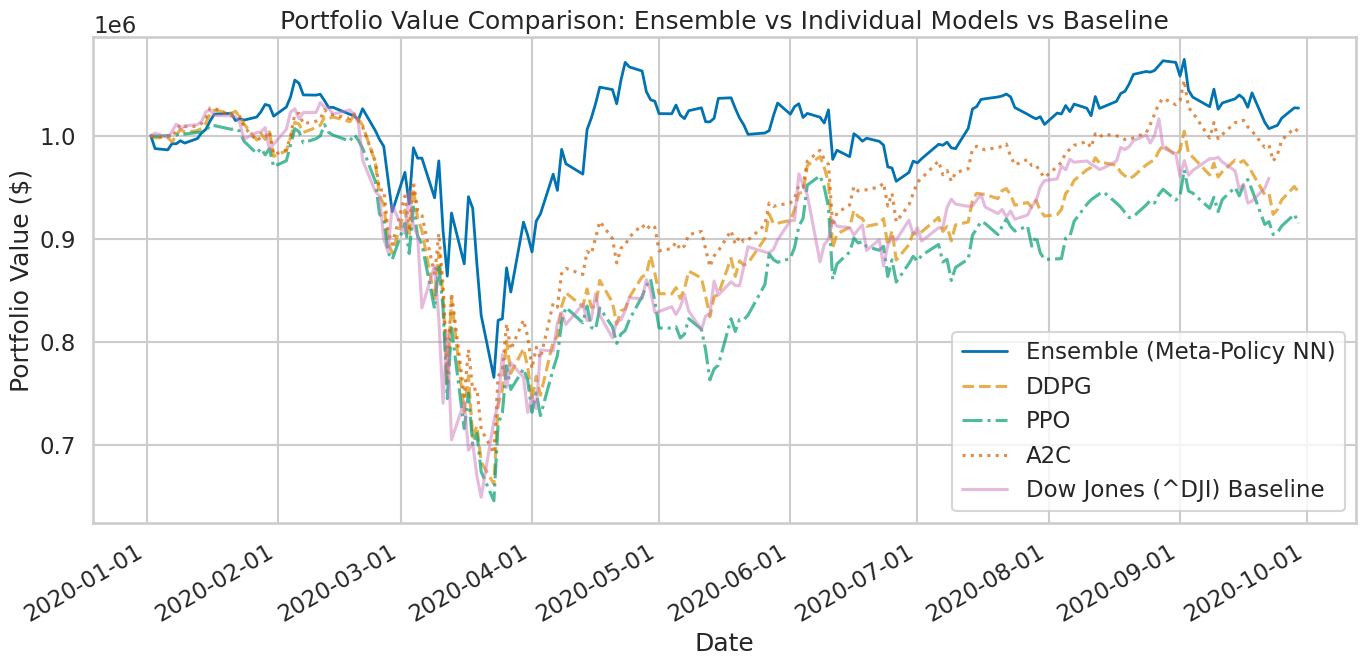

In [101]:
# Set a Seaborn theme for a cleaner look
sns.set_theme(style='whitegrid', context='talk')

# Optionally, define a Seaborn color palette
palette = sns.color_palette("colorblind", 5)

# Convert 'date' columns to datetime if they are not already
ensemble_results['date'] = pd.to_datetime(ensemble_results['date'])
ddpg_results['date'] = pd.to_datetime(ddpg_results['date'])
ppo_results['date'] = pd.to_datetime(ppo_results['date'])
a2c_results['date'] = pd.to_datetime(a2c_results['date'])
dji['date'] = pd.to_datetime(baseline_df['date'])

# Create the figure
plt.figure(figsize=(14, 7))

# Plot each series using Seaborn's palette for consistency
plt.plot(ensemble_results['date'], ensemble_results['account_value'], 
         label='Ensemble (Meta-Policy NN)', linewidth=2, color=palette[0])
plt.plot(ddpg_results['date'], ddpg_results['account_value'], 
         label='DDPG', linestyle='--', alpha=0.7, color=palette[1])
plt.plot(ppo_results['date'], ppo_results['account_value'], 
         label='PPO', linestyle='-.', alpha=0.7, color=palette[2])
plt.plot(a2c_results['date'], a2c_results['account_value'], 
         label='A2C', linestyle=':', alpha=0.7, color=palette[3])
plt.plot(dji['date'], dji['close'], 
         label='Dow Jones (^DJI) Baseline', linestyle='-', alpha=0.5, color=palette[4])

# Format the x-axis for dates
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()

# Add titles and labels
plt.title('Portfolio Value Comparison: Ensemble vs Individual Models vs Baseline')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()


### Training (Third Iteration)